<a href="https://colab.research.google.com/github/ashalem/ML_Human/blob/main/HW5_W2024_students_eb61.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div>Machine Learning and Human Behavior - 236667 - Winter 2024-2025</div>
<font size="6">Homework #5 - Promoting content 💸</font>
<font size="4">IDS: Ariel Shalem, 316333368, Eden Strugo 314884602</font>


# Instructions and submission guidelines

* Clone this notebook and complete the exercise:
    * Aim for clear and concise solutions.
    * Indicate clearly with a text block the sections of your solutions.
    * Answer dry questions in markdown blocks, and wet questions in code blocks.
* Submission guidelines:
    * Add a text block in the beginning of your notebook with your IDs.
    * When you're done, restart the notebook and make sure that everything runs smoothly (Runtime->"Restart and Run All")
    * Export your notebook as ipynb (File->Download->"Download .ipynb")
    * If you need to attach additional files to your submission (e.g images), add them to a zip file together with the notebook ipynb file.
    * Submit through the course website. Remember to list partner IDs when you submit.
* **Due date**: Sunday 26/01/2025, 10:00
* For any questions regarding this workshop, contact [Eden](mailto:edens@campus.technion.ac.il).

# Introduction

In our next workshop, we will continue to explore recommendation system dynamics, and dive into new and interesting recommendation settings. The goal of this homework task is to introduce you to the environment that we'll use.

In [1]:
%pip install scikit-surprise

import itertools

import pandas as pd
import numpy as np
import scipy.stats
import IPython.display
import copy

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import surprise

from tqdm.auto import tqdm


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Environment from Workshop 4

Workshop 5 will use the same infrastructure we used in Workshop 4. The following cell contains the definitions of `TopicsStatic`, `TopicsDynamic`, and `trainset_from_df`. Run it to define the class of environments:

In [2]:
class TopicsStatic:
    topic_affinity_params = dict(
        low=0.5,
        high=5.5,
    )
    decision_noise_params = dict(
        scale=0.5,
    )
    rating_frequency = 0.2

    def __init__(self, n_users, n_items, n_topics, n_initial_ratings, random_state=None):
        """
        Initialize the environment.

        Parameters
        ----------
        n_users : int
            Number of users in the environment.

        n_items : int
            Number of items in the environment.

        n_topics : int
            Number of latent topics in the environment.

        n_initial_ratings : int
            Number of initial ratings available to the recommender before the
            simulation starts.

        random_state : int, default=None
            Random seed to use, if none is specified, a seed provided by the
            OS will be used.
        """
        self.n_users = n_users
        self.n_items = n_users
        self.all_users = [f'usr_{i}' for i in range(self.n_users)]
        self.all_items = [f'itm_{i}' for i in range(self.n_items)]
        self.n_topics = n_topics
        self.n_initial_ratings = n_initial_ratings
        self.rng = np.random.default_rng(random_state)
        # Assign topics to items
        self._item_topics = self.rng.integers(
            low=0,
            high=n_topics,
            size=n_items
        )
        # Initialize topics affinity matrix
        self._topic_affinity = self.rng.uniform(
            **self.topic_affinity_params,
            size=(n_users, n_topics),
        )
        # Initialize environment state
        self.t = 0
        self.last_online_users = None
        self.seen_items = {user_id: list() for user_id in self.all_users}
        self.initial_ratings_shown = False

    def _get_rating(self, user_id, item_id):
        """
        Calculate rating r_t(user_id, item_id).
        """
        assert item_id not in self.seen_items[user_id], (
            'Each item can only be shown once to each user'
        )
        user_internal_id = self.all_users.index(user_id)
        item_internal_id = self.all_items.index(item_id)
        self.seen_items[user_id].append(item_id)
        item_topic = self._item_topics[item_internal_id]
        affinity = self._topic_affinity[user_internal_id, item_topic]
        noise = self.rng.normal(**self.decision_noise_params)
        rating = np.clip(affinity+noise, 1, 5)
        return rating

    def _get_latent_topic(self, item_id):
        item_internal_id = self.all_items.index(item_id)
        return self._item_topics[item_internal_id]

    def get_initial_ratings(self):
        """
        Get initial ratings, to be used when initializing the recommender.

        Returns
        -------
        ratings_df : pandas.DataFrame
            DataFrame with columns: user_id, item_id, rating, timestamp.
            Timestamp for initial data is set to 0.
        """
        assert not self.initial_ratings_shown, (
            'Initial ratings can only be calculated once',
        )
        all_pairs = list(itertools.product(
            self.all_users,
            self.all_items,
        ))
        selected_pairs = self.rng.choice(
            a=all_pairs,
            size=self.n_initial_ratings,
            replace=False,
        )
        ratings = [
            (user_id, item_id, self._get_rating(user_id, item_id))
            for user_id, item_id in selected_pairs
        ]
        self.initial_ratings_shown = True
        return pd.DataFrame(
            data=ratings,
            columns=('user_id','item_id','rating')
        ).assign(timestamp=self.t)

    def get_online_users(self):
        """
        Returns the set of online users that queried the system at the
        current time step.

        Returns
        -------
        online_users: array of user_ids
        """
        assert self.last_online_users is None, (
            'Previous batch of online users must get recommendations'
        )
        n_online = self.rng.binomial(
            n=self.n_users,
            p=self.rating_frequency,
        )
        online_users = self.rng.choice(
            a=self.all_users,
            size=n_online,
            replace=False,
        )
        self.last_online_users = set(online_users)
        return online_users

    def recommend(self, recommendations):
        """
        Recommend items to users.

        Parameters
        ----------
        recommendations : list of (user_id, item_id) tuples.
            Each (user_id, item_id) tuple corresponds to an item recommended
            to an online user. Note that only unseen items can be recommended,
            and all online users must receive recommendations.

        Returns
        -------
        ratings_df : pandas.DataFrame
            True ratings given by the users.
            DataFrame with columns: user_id, item_id, rating, timestamp.
            Timestamp for recommendations is >= 1.
        """
        assert self.last_online_users is not None, (
            'Online users must be selected by calling get_online_users()'
        )
        assert len(recommendations)==len(self.last_online_users), (
            'Number of recommendations must match number of online users'
        )
        assert {user_id for user_id, _ in recommendations}==self.last_online_users, (
            'Users given recommendations must match online users'
        )
        assert all(item_id not in self.seen_items[user_id] for user_id, item_id in recommendations), (
            'Only unseen items can be recommended'
        )
        ratings = [
            (user_id, item_id, self._get_rating(user_id, item_id))
            for user_id, item_id in recommendations
        ]
        self.last_online_users = None
        self.t += 1
        return pd.DataFrame(
            data=ratings,
            columns=('user_id','item_id','rating')
        ).assign(timestamp=self.t)

    def get_unseen_items(self, user_id):
        """
        Get a list of items that the user didn't see yet.

        Parameters
        ----------
        user_id : int

        Returns
        -------
        unseen_items : list of int
            ids of unseen items.
        """
        return [
            item_id
            for item_id in self.all_items
            if item_id not in self.seen_items[user_id]
        ]


class TopicsDynamic(TopicsStatic):
    def __init__(self, a, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.a = a

    def recommend(self, recommendations):
        # Recommend and get ratings
        ratings_df = super().recommend(recommendations)
        # Update affinity
        for row in ratings_df.itertuples():
            user_internal_id = self.all_users.index(row.user_id)
            item_internal_id = self.all_items.index(row.item_id)

            # increase affinity for selected item topic
            selected_topic = self._item_topics[item_internal_id]
            self._topic_affinity[user_internal_id, selected_topic] += self.a
            # decrease affinity for other topics
            not_selected = np.arange(self.n_topics) != selected_topic
            self._topic_affinity[user_internal_id, not_selected] -= (
                self.a / (self.n_topics-1)
            )
            # clip
            self._topic_affinity[user_internal_id] = (
                self._topic_affinity[user_internal_id].clip(min=0.5, max=5.5)
            )
        # Return ratings dataframe
        return ratings_df


def trainset_from_df(df):
    """
    Convert DataFrame to Surprise training set.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with columns [user_id, item_id, rating]

    Returns
    -------
    trainset : surprise.Trainset
    """
    dataset = surprise.Dataset.load_from_df(
        df=df[['user_id','item_id','rating']],
        reader=surprise.Reader(rating_scale=(1,5)),
    )
    return dataset.build_full_trainset()


# Homework task: Promoting content

The goal of this homework assignment is to introduce you to the environment that we'll use in Workshop 5.

We will consider the `TopicsStatic` environment (introduced in the previous workshop), in which each item has a topic and users prefer certain topics over others. In this exercise, however, we introduce *suppliers* into the environment. Each supplier owns one topic (so that the number of  suppliers is equal to the number of topics $K$), and profits when users consume items of that topic:
Whenever an item from topic $k\in[K]$ is recommended by the system to some user $u$, supplier $k$ gets paid.

The recommendation system allows suppliers to influence recommendations through a *promotion system*: Before each time step, each supplier can place a bid of some amount; the higher the amount supplier $k$ bids, the more likely it is for the system to recommend to users items from topic $k$.

More specifically, at each timestep $t$:
1. Suppliers $1,\dots,K$ place bids $b_t^{(1)},\dots,b_t^{(K)} \ge 0$ to participate in the promotion process. They can choose how much to bid, but cannot bid more than they currently have.
2. The system sorts the suppliers by their bids, and ties are broken lexicographically. Denote the position of topic $k$ in the sorted list by $\mathrm{pos}_t(k)\in\{1,\dots,K\}$.
3. For each user, the system predicts the ratings of items $\hat{r}_t(u,x)$, as it is prediction based and
recommends the items with the highest predicted ratings.
4. For each rating prediction of an item of topic $k$, the system adds a promotion bias $\beta_k$ to the
prediction, where:
$$
\beta_t^{(k)}=B\left(2\frac{K-\mathrm{pos}_t(k)}{K-1} - 1\right)
$$
This way, the supplier who bid the highest ($\mathrm{pos}_t(k)=1$) will get a bias of $B$, the supplier who bid the lowest value ($\mathrm{pos}_t(k)=K$) will get a bias of $-B$, and the supplier who bid the median amount will get a bias of $0$. In our code, we refer to $B$ as the *promotion factor*.
5. After calculating the promotion bias terms, the system recommends items according to the modified predictions (original predictions with the added biases):
$$
x_u = \mathrm{argmax}_{x\in X} \hat{r}_t(u,x) + \beta_t^{(k_x)}
$$

6. The supplier of topic $k$ receives $m_t^{(k)}$ dollars, where:
$$
m_t^{(k)}=100\frac{\text{number of items of topic $k$ recommended}}{\text{number of recommendations in this step}}
$$

In the beginning of the simulation, all suppliers have $100. To simplify, at each time step, all
suppliers bid a random amount of money between 0 and 50% of the money they currently have.



## Parameters

We use the following parameters for simulation:

In [3]:
# TopicsDynamic
topics_params = {
    'n_users': 100,
    'n_items': 200,
    'n_topics': 10,
    'n_initial_ratings': 500,
}

# surprise.SVD
svd_model_params = {
    'n_factors': 16,
}



## Implementation


### `BiddingAgent`
Suppliers' bidding policies are implemented by inheriting from the `BiddingAgent` class:

In [4]:
class BiddingAgent:
    """
    Generic class for simulating a bidding agent (supplier)
    """
    def __init__(self, initial_budget, random_state=None):
        """
        Initialize the bidding agent.

        Parameters
        ----------
        initial_budget : float
            Initial budget (non-negative)
        random_state : Seed. Valid input to `np.random.default_rng`.
        """
        assert initial_budget>=0, 'Initial budget must be nonnegative.'
        self.initial_budget = initial_budget
        self._remaining_budget = initial_budget
        self.rng = np.random.default_rng(random_state)
        self.payment_history = []

    def calculate_bid(self, context=None):
        """
        Return the raw bid, to be implemented by subclasses.
        The `place_bid` function validates the value returned.

        Parameters
        ----------
        context : any
            a context parameter for informed decision-making.

        Returns
        -------
        bid : float
            bid for next promotion.
        """
        raise NotImplementedError

    def remaining_budget(self):
        """
        Get the remaining budget of the bidding agent.

        Returns
        -------
        remaining_budget : float
        """
        return self._remaining_budget

    def transfer_funds(self, m):
        """
        Transfer/receive funds resulting from recommendations.
        Negative value of `m` represents tranfer of funds from the agent
        to the system, and a positive value of `m` represents a payment
        from the system to the agent.

        Parameters
        ----------
        m : float
            Amount of pay.
        """
        assert self._remaining_budget+m>=0, (
            'Each payment must preserve a non-negative budget'
        )
        self._remaining_budget += m
        self.payment_history.append(m)



### `RandomFractionBiddingAgent`

The `RandomFractionBiddingAgent` class implements the random bidding policy described in the previous section:

In [5]:
class RandomFractionBiddingAgent(BiddingAgent):
    """
    Agent simulating a random bidding policy.
    At each step, suppliers of this type bid a random amount of money
    between 0 and half the money they currently have.
    """
    def calculate_bid(self, context):
        return self.rng.uniform(low=0.0,high=0.5)*self.remaining_budget()


### `SuppliersGroup`

The `SuppliersGroup` describes the collective of bidding agents:

In [6]:
class SuppliersGroup:
    def __init__(self, agents):
        """
        Initialize the suppliers group.

        Parameters
        ----------
        agents : list of BiddingAgent
        """
        self.agents = agents

    def calculate_bids(self, context):
        return [agent.calculate_bid(context) for agent in self.agents]

    def transfer_funds(self, payment_vector):
        for agent,payment in zip(self.agents, payment_vector):
            agent.transfer_funds(payment)

    def __len__(self):
        return len(self.agents)

    def __iter__(self):
        return iter(self.agents)

    def __getitem__(self,i):
        return self.agents[i]



### Simulator

The `simulate_recommendations_with_bidding` function runs the simulation. It returns two DataFrames - One with recommendations and responses, and another with budgets and payments.

In [7]:
def simulate_recommendations_with_bidding(
    env,
    cf_model,
    suppliers,
    num_steps,
    payment_per_step,
    promotion_factor,
):
    """
    Simulate recommendations with bidding.

    Parameters
    ----------
    env : TopicsStatic

    cf_model : surprise.AlgoBase

    num_steps : int
        Length of simulation.

    payment_per_step : float
        Total payment to suppliers per step

    promotion_factor : float
        Promotion factor B

    Returns
    -------
    recommendations_df : pandas.DataFrame
        pandas DataFrame with all recommendations. Each row represents a
        recommendation. Each recommendation is associated with a timestamp,
        user id, item id, predicted rating, actual rating, and latent topic.

    payment_df : pandas.DataFrame
        pandas DataFrame with all payment information. Each row represents
        the behavior of a supplier (and its consequences) for a given time
        step.
    """
    assert isinstance(env, TopicsStatic), (
        'env must be an instance of TopicsStatic or one of its subclasses'
    )
    K = env.n_topics
    assert K == len(suppliers), (
        'Length of supplier list must match number of topics'
    )
    recommendation_results = []
    payment_results = []

    # Fit initial CF model
    recommendation_results = [env.get_initial_ratings()]
    cf_model.fit(trainset_from_df(recommendation_results[0]))

    # Simulate dynamics
    for t in tqdm(range(num_steps)):
        online_users = env.get_online_users()
        recommendations = {}
        # Calculate promotion factors
        bids = suppliers.calculate_bids(context=None)
        for agent,bid in zip(suppliers,bids):
            assert bid>=0, 'Bids must be positive'
            agent.transfer_funds(-bid)
        pos = K-(scipy.stats.rankdata(bids, method='ordinal')-1)
        beta = promotion_factor*2*((K-pos)/(K-1) - 0.5)
        payment = np.zeros(K)

        # Recommend
        for user_id in online_users:
            # Predict ratings
            predicted_ratings = {
                item_id: cf_model.predict(user_id, item_id).est
                for item_id in env.get_unseen_items(user_id)
            }
            # Add promotion bias
            predicted_ratings_with_bias = {
                item_id: predicted_rating + beta[env._item_topics[env.all_items.index(item_id)]]
                for item_id, predicted_rating
                in predicted_ratings.items()
            }
            selected_item = max(
                predicted_ratings_with_bias.items(),
                key=lambda t: t[1],
            )[0]
            recommendations[(user_id, selected_item)] = predicted_ratings[selected_item]
            payment[env._item_topics[env.all_items.index(selected_item)]] += payment_per_step/len(online_users)

        ratings = env.recommend(list(recommendations))

        # Record results
        recommendation_results.append(
            ratings
            .assign(
                predicted_rating=lambda df: df.apply(
                    lambda row: recommendations[(row['user_id'], row['item_id'])],
                    axis=1,
                ),
                latent_topic=lambda df: df['item_id'].map(
                    lambda item_id: env._item_topics[env.all_items.index(item_id)]
                ),
            )
        )

        # Retrain
        cf_model.fit(trainset_from_df(pd.concat(recommendation_results)))

        # Pay and record remaining budgets
        for topic_k,agent in enumerate(suppliers):
            agent.transfer_funds(payment[topic_k])
            payment_results.append({
                'timestamp': t+1,
                'supplier': topic_k,  # supplier id
                'bid': bids[topic_k],  # supplier bid
                'position': pos[topic_k],  # pos_t(k)
                'boost': beta[topic_k],  # beta_t^k
                'revenue': payment[topic_k],  # payment made to supplier k
                'remaining_budget': agent.remaining_budget(),  # remaining budget
            })

    return (
        pd.concat(recommendation_results),  # recommendations_df
        pd.DataFrame(payment_results),  # payments_df
    )



## Exercise 1.1: Simulation

Run the following code to simulate the dynamics. Make sure you understand the output.

🔵 **Results**:

In [8]:
random_recommendation_rng = np.random.default_rng(1234)

random_recommendation_results_df, random_payments_df = simulate_recommendations_with_bidding(
    # environment
    env=TopicsStatic(
        random_state=random_recommendation_rng,
        **topics_params
    ),
    # prediction model
    cf_model=surprise.SVD(
        random_state=random_recommendation_rng.integers(9999),
        **svd_model_params,
    ),
    # suppliers
    suppliers=SuppliersGroup(
        agents=[
            RandomFractionBiddingAgent(
                initial_budget=100,
                random_state=random_recommendation_rng,
            )
            for k in range(topics_params['n_topics'])
        ]
    ),
    # promotion parameters
    payment_per_step=100,
    promotion_factor=0.5,
    # simulation length
    num_steps=100,
)

display(
    random_recommendation_results_df.tail()
    .style.set_caption('random_recommendation_results_df')
)
display(
    random_payments_df.tail()
    .style.set_caption('random_payments_df')
)


  0%|          | 0/100 [00:00<?, ?it/s]

,user_id,item_id,rating,timestamp,predicted_rating,latent_topic
24,usr_85,itm_22,2.228848,100,3.279000,2.000000
25,usr_89,itm_35,3.881940,100,4.091225,2.000000
26,usr_21,itm_27,1.000000,100,2.046488,8.000000
27,usr_62,itm_99,4.566030,100,2.684705,2.000000
28,usr_1,itm_39,1.704430,100,2.014103,8.000000


,timestamp,supplier,bid,position,boost,revenue,remaining_budget
995,100,5,0.159696,5,0.055556,0.000000,0.500205
996,100,6,0.000000,10,-0.500000,0.000000,0.000000
997,100,7,0.000000,8,-0.277778,0.000000,0.000000
998,100,8,25.765991,1,0.500000,24.137931,106.976130
999,100,9,0.000000,6,-0.055556,0.000000,0.000000


Run the following code to generate a plot of suppliers' budget over time.

🔵 **Results**:

<Axes: title={'center': 'Remaining budget over time for different suppliers'}, xlabel='Time ($t$)', ylabel='Remaining budget'>

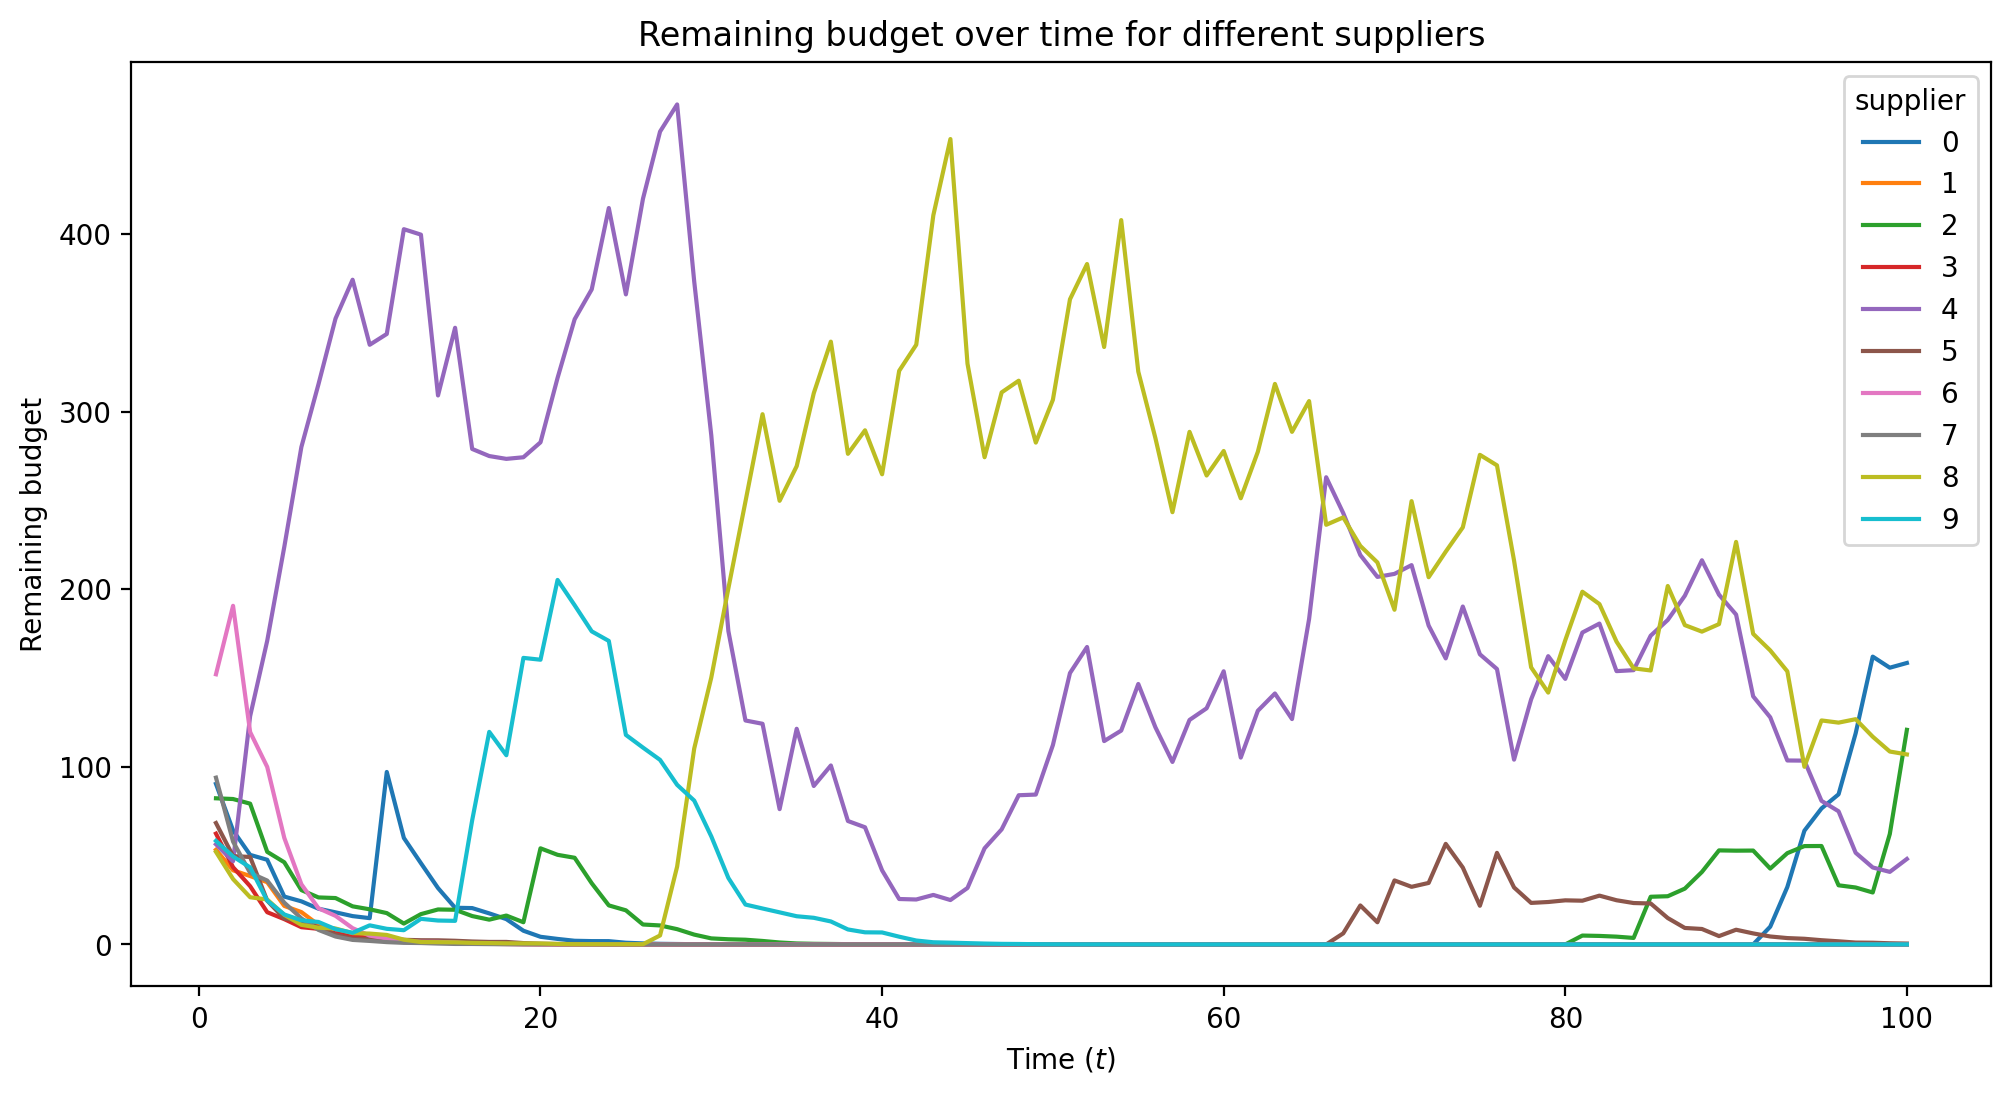

In [9]:
(
    random_payments_df
    .pivot(
        index='timestamp',
        columns='supplier',
        values='remaining_budget',
    )
    .plot.line(
        title='Remaining budget over time for different suppliers',
        xlabel='Time ($t$)',
        ylabel='Remaining budget',
        figsize=(12,6),
    )
)

Find the supplier with the highest remaining budget at the end of the run, and the supplier with the lowest remaining budget at the end of the run. Plot their remaining budget over time:

🔵 **Answer**:


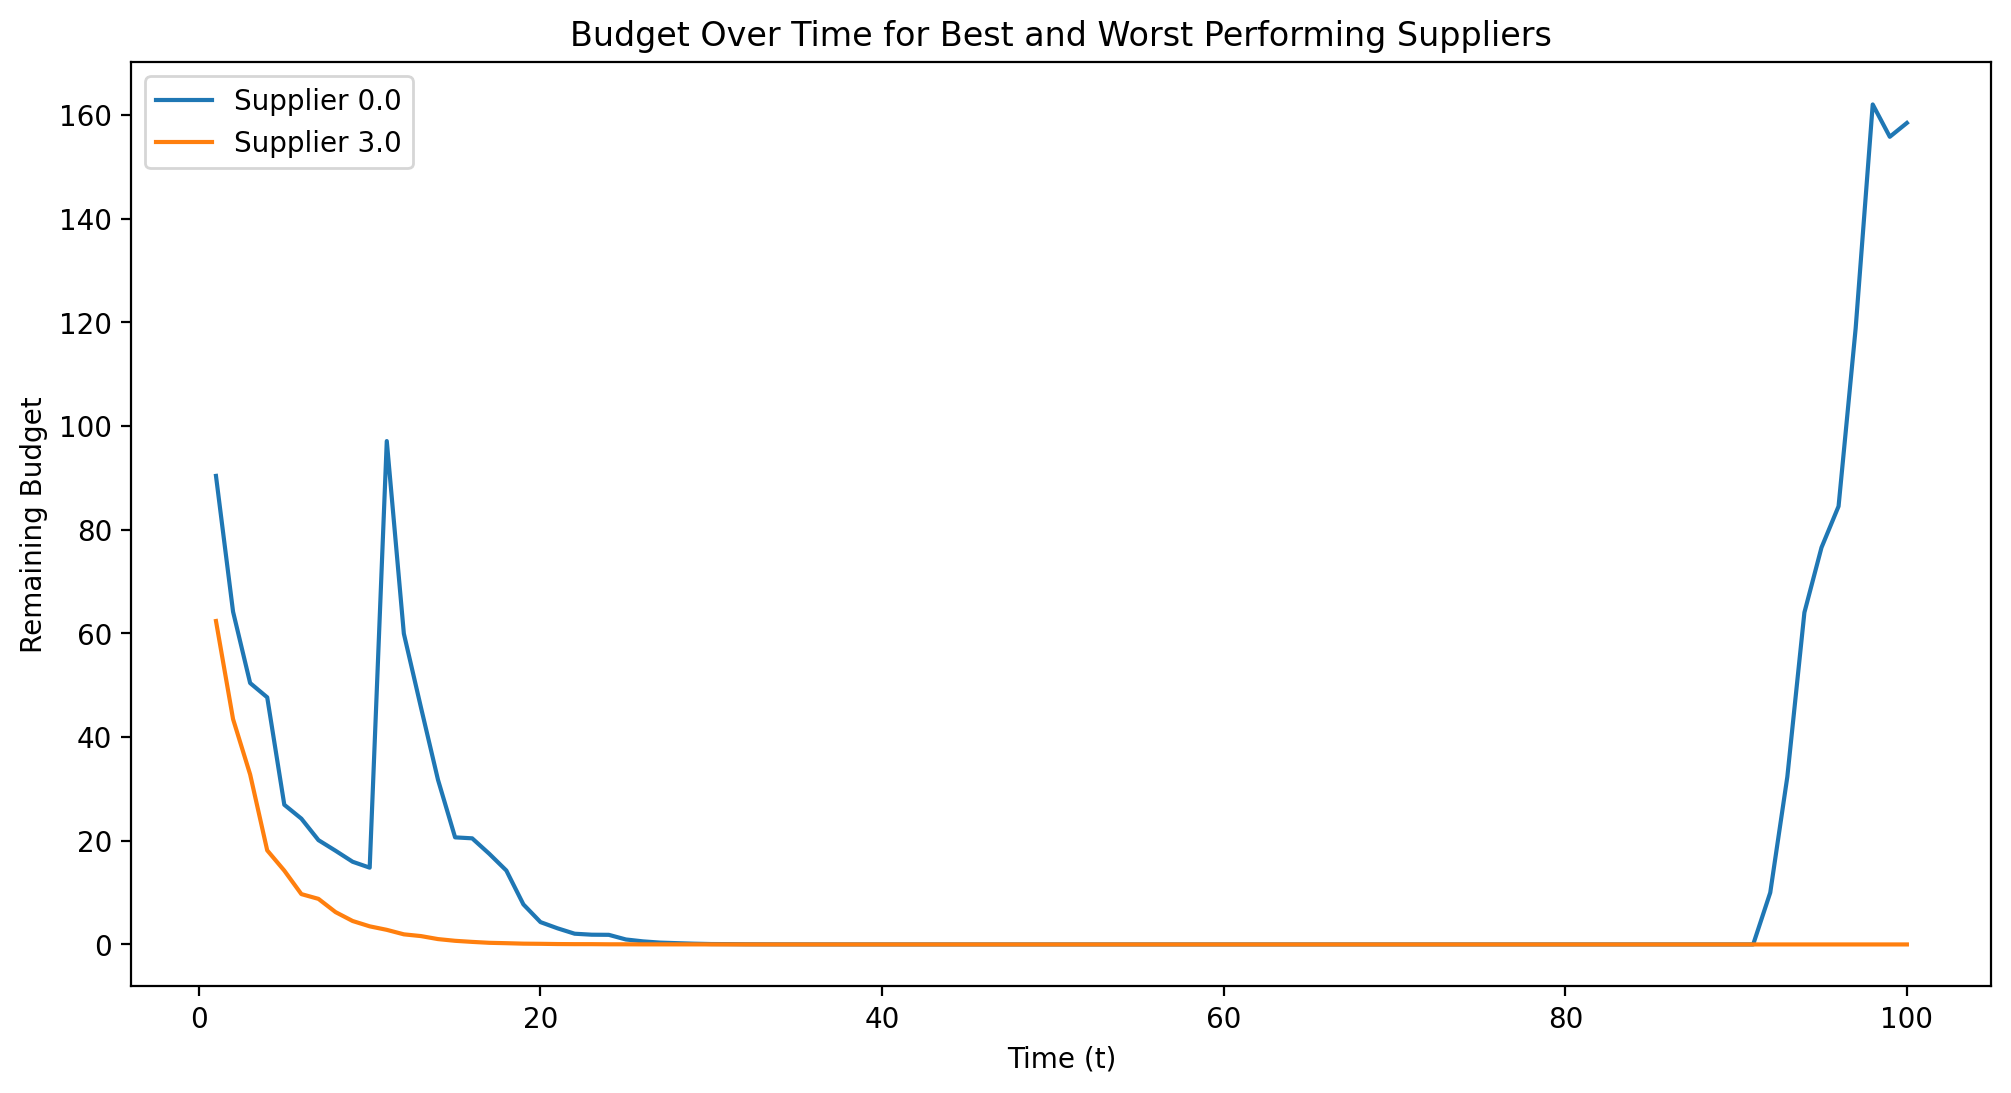

In [10]:
## YOUR SOLUTION
final_budgets = random_payments_df[random_payments_df['timestamp'] == random_payments_df['timestamp'].max()]
highest_supplier = final_budgets.loc[final_budgets['remaining_budget'].idxmax()]['supplier']
lowest_supplier = final_budgets.loc[final_budgets['remaining_budget'].idxmin()]['supplier']

plt.figure(figsize=(12,6))
for supplier in [highest_supplier, lowest_supplier]:
    supplier_data = random_payments_df[random_payments_df['supplier'] == supplier]
    plt.plot(supplier_data['timestamp'], supplier_data['remaining_budget'], 
             label=f'Supplier {supplier}')

plt.title('Budget Over Time for Best and Worst Performing Suppliers')
plt.xlabel('Time (t)')
plt.ylabel('Remaining Budget')
plt.legend()
plt.show()



Provide an explanation for why they differ.

🔵 **Answer**:

For starters the agents have random behavior as described in the exercise, so they will get different results.
Also, each supplier has a different topic associated with it, so the topic popularity will affect the results of the agents.
Also, specifically here, supplier number 3 might have a not so popular topic, so in the start of the simulation his big bids did not pay off so much. Because the bids are then sorted, if he didn't get one of the top positions, he will not get any revenue, meaning he lost money on the bid and also in later stages he will not be able to catch up.

The `payments_df` dataframe contains a column `revenue` with the payment received by each agent in each step. Create a bar plot comparing the total revenues of the suppliers over the entire run:

🔵 **Solution**:

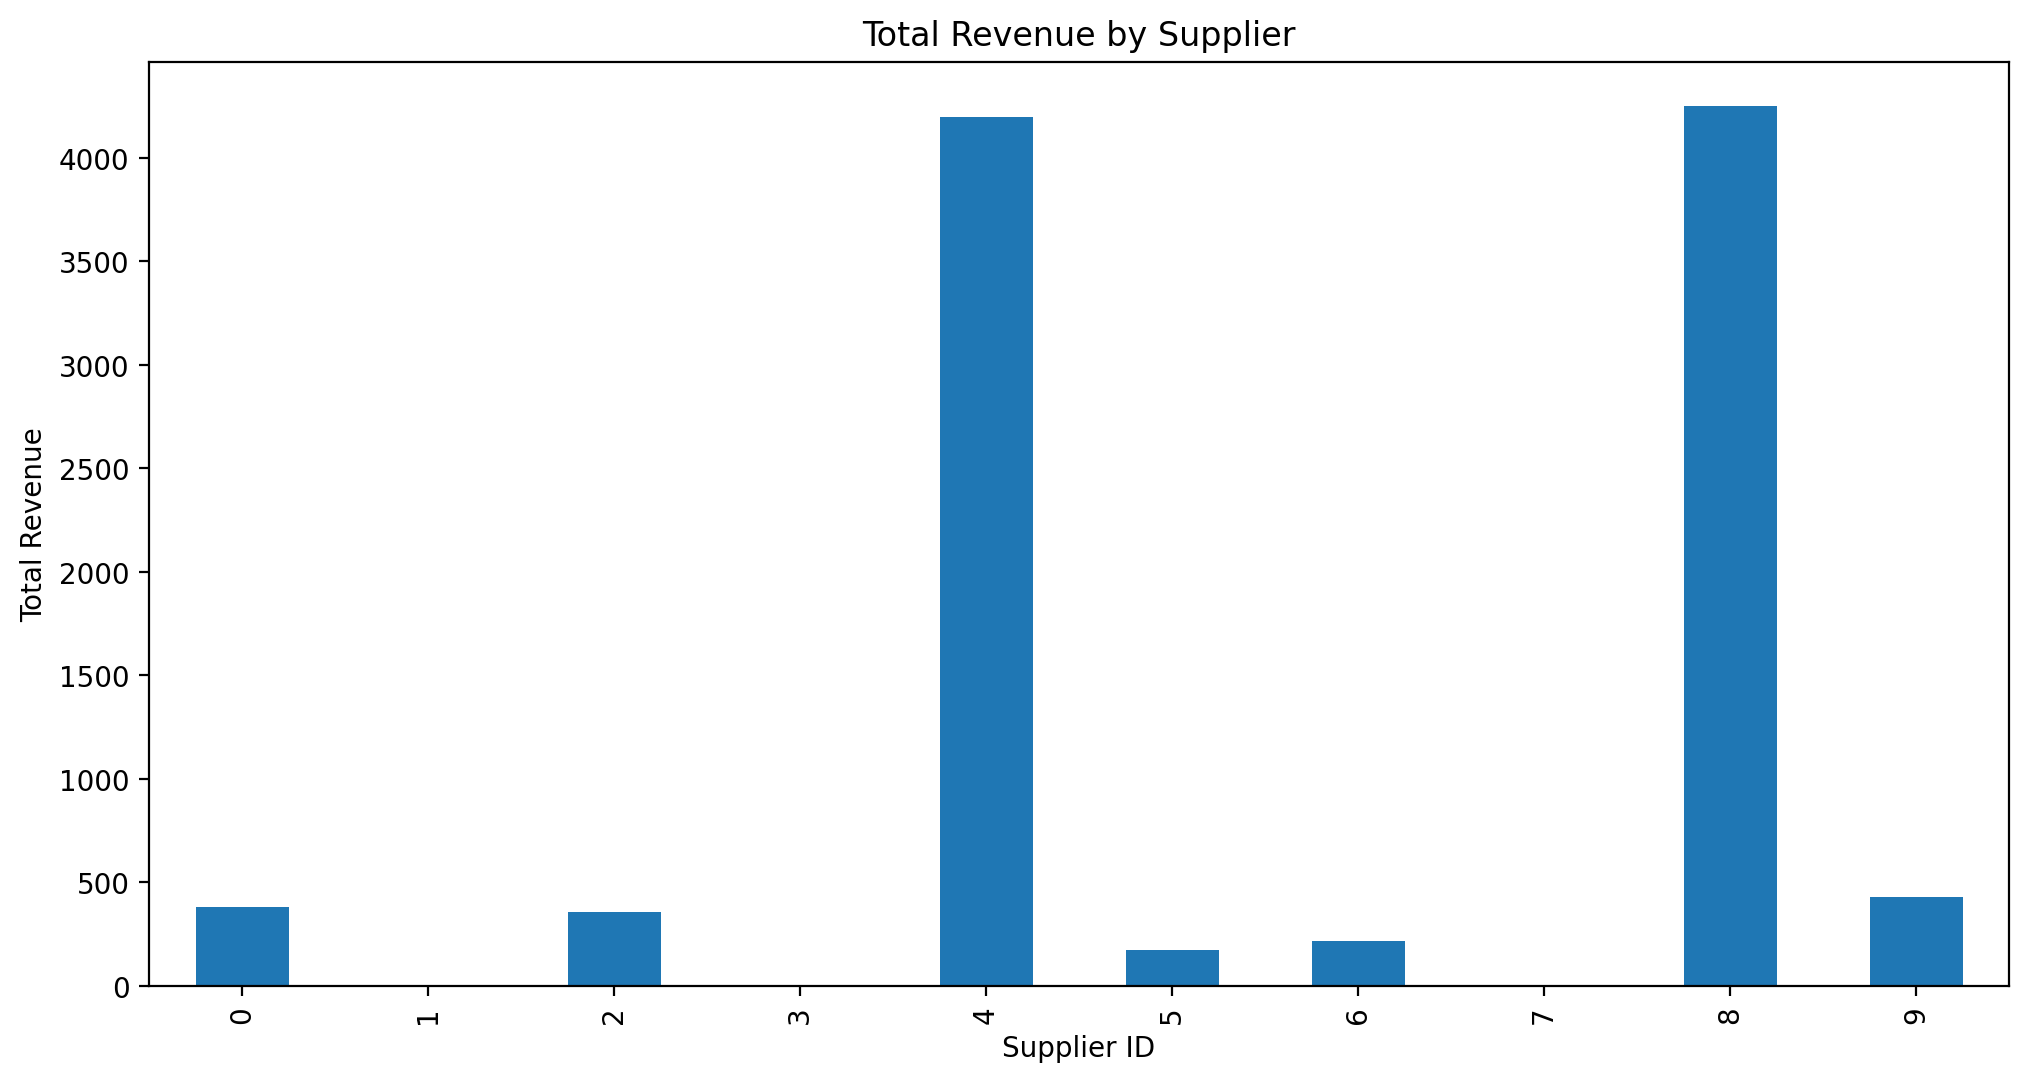

In [11]:
## YOUR SOLUTION
total_revenue = random_payments_df.groupby('supplier')['revenue'].sum()

plt.figure(figsize=(12,6))
total_revenue.plot(kind='bar')
plt.title('Total Revenue by Supplier')
plt.xlabel('Supplier ID')
plt.ylabel('Total Revenue')
plt.show()

What do you observe in the plot? What are the implications on content diversity?


🔵 **Answer**:

- It is obvious that there is a split between the suppliers, few suppliers got most of the revenue, and the rest got very little. This is because once a supplier winds in a bid and gets a revenue, she will be able to bid more in the next steps, and therefore will get the top spot more often, which will lead to more revenue and so on.
- The system is sensitive to the topic popularity, looking at supplier 0 is a good example, even though this supplier lost on the bids, and didn't have budget most of the steps, at the end of the simulation he got the most revenue, this is because the topic is popular, and the system recommended more items from this topic, even though the supplier didn't have bids.



## Exercise 1.2: Insider trading

You are an employee in the recommendation system’s company, and your uncle is supplier
number $1$ (supplier of index `0`, who owns items of topic $k=1$). Your uncle is asking you to help him increase his profits.

Working in the recommendation system’s company, you have access to the bid values of all
suppliers at each time step. Use this information to suggest a bidding policy for your uncle: the
goal is to maximize supplier $1$’s average income over the course of the simulation (this value was calculated in the previous step).

Tell your uncle how much he should bid in each time step by overriding the designated section in the code below.

🔵 **Answer**:

In [16]:
class OmniscientBiddingAgent(BiddingAgent):
    def calculate_bid(self, context):
        # This function should return a positive float representing the
        # selected bid.
        # `other_bids` is a list of floats of length K-1, containing the
        # bids of the other suppliers for the current time step.
        other_bids = context['other_bids']
        ## YOUR SOLUTION
        
        highest_other_bid = sorted(other_bids, reverse=True)[0]
        optimal_bid = highest_other_bid + 0.1
        
        if optimal_bid <= self.remaining_budget():
            return optimal_bid
        
        return 0

We will now evaluate the chosen strategy.

The `InsiderTradingSuppliersGroup` class injects the bids of the other agents ("insider information") into the context of the omniscient agent:

In [27]:
class InsiderTradingSuppliersGroup(SuppliersGroup):
    def __init__(self, omniscient_agent, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.omniscient_agent = omniscient_agent

    def __len__(self):
        return len(self.agents)+1

    def __iter__(self):
        return iter([self.omniscient_agent]+self.agents)

    def __getitem__(self,i):
        return ([self.omniscient_agent]+self.agents)[i]

    def calculate_bids(self, context):
        other_bids = super().calculate_bids(context)
        context = context or {}
        context['other_bids'] = other_bids
        omniscient_bid = self.omniscient_agent.calculate_bid(context)
        bids = [omniscient_bid] + other_bids
        print(bids)
        return bids

The following code simulates the dynamics in the presence of an omniscient agent. Run the simulation and obtain the results.

🔵 **Results**:

In [28]:
omniscient_recommendation_rng = np.random.default_rng(1234)

# Simulate
omniscient_recommendation_results_df, omniscient_payments_df = simulate_recommendations_with_bidding(
    # environment
    env=TopicsDynamic(
        **topics_params,
        a=0.0,
        random_state=omniscient_recommendation_rng,
    ),
    # prediction model
    cf_model=surprise.SVD(
        **svd_model_params,
        random_state=omniscient_recommendation_rng.integers(9999),
    ),
    # suppliers
    suppliers = InsiderTradingSuppliersGroup(
        # Random-bidding agents
        agents=[
            RandomFractionBiddingAgent(
                initial_budget=100,
                random_state=omniscient_recommendation_rng,
            )
            for k in range(topics_params['n_topics']-1)
        ],
        # Initialize omniscient bidding agent (your uncle)
        omniscient_agent=OmniscientBiddingAgent(
            initial_budget=100,
            random_state=omniscient_recommendation_rng,
        ),
    ),
    # promotion parameters
    payment_per_step=100,
    promotion_factor=1.5,
    # simulation length
    num_steps=5,
)

  0%|          | 0/5 [00:00<?, ?it/s]

[48.006815767839754, 9.615188635685207, 46.702762009268135, 17.72096222868134, 37.609850850262845, 43.6103728407626, 31.636839294585826, 47.90681576783975, 6.093758332769905, 47.89364682818015]
[36.09276133006953, 26.192422807305025, 11.560475659775603, 0.4097659846150727, 18.921394065390132, 9.540426860101276, 18.62927815490656, 21.04850727197594, 35.99276133006953, 15.301653718859558]
[18.42999328248821, 13.768545069862993, 3.231062330397108, 2.6104998123588006, 10.677194883366877, 18.329993282488207, 0.48738032095521133, 11.573929297328748, 17.635654305310744, 10.232375334944864]
[14.677557028531108, 14.577557028531109, 2.5818073999940574, 1.114107544415169, 6.6301207223169545, 12.220388730231472, 12.985836921738562, 5.994504147710159, 2.2023957327662584, 2.3866266239486946]
[28.27409917043941, 15.040177199183601, 2.8576207956396473, 28.17409917043941, 9.748779009774301, 2.5212718444334343, 12.170772894686085, 5.351728959817607, 10.07191927971368, 6.9831543333116795]


<Axes: title={'center': 'Revenue accumulation over time for different suppliers'}, xlabel='Time ($t$)', ylabel='Revenue'>

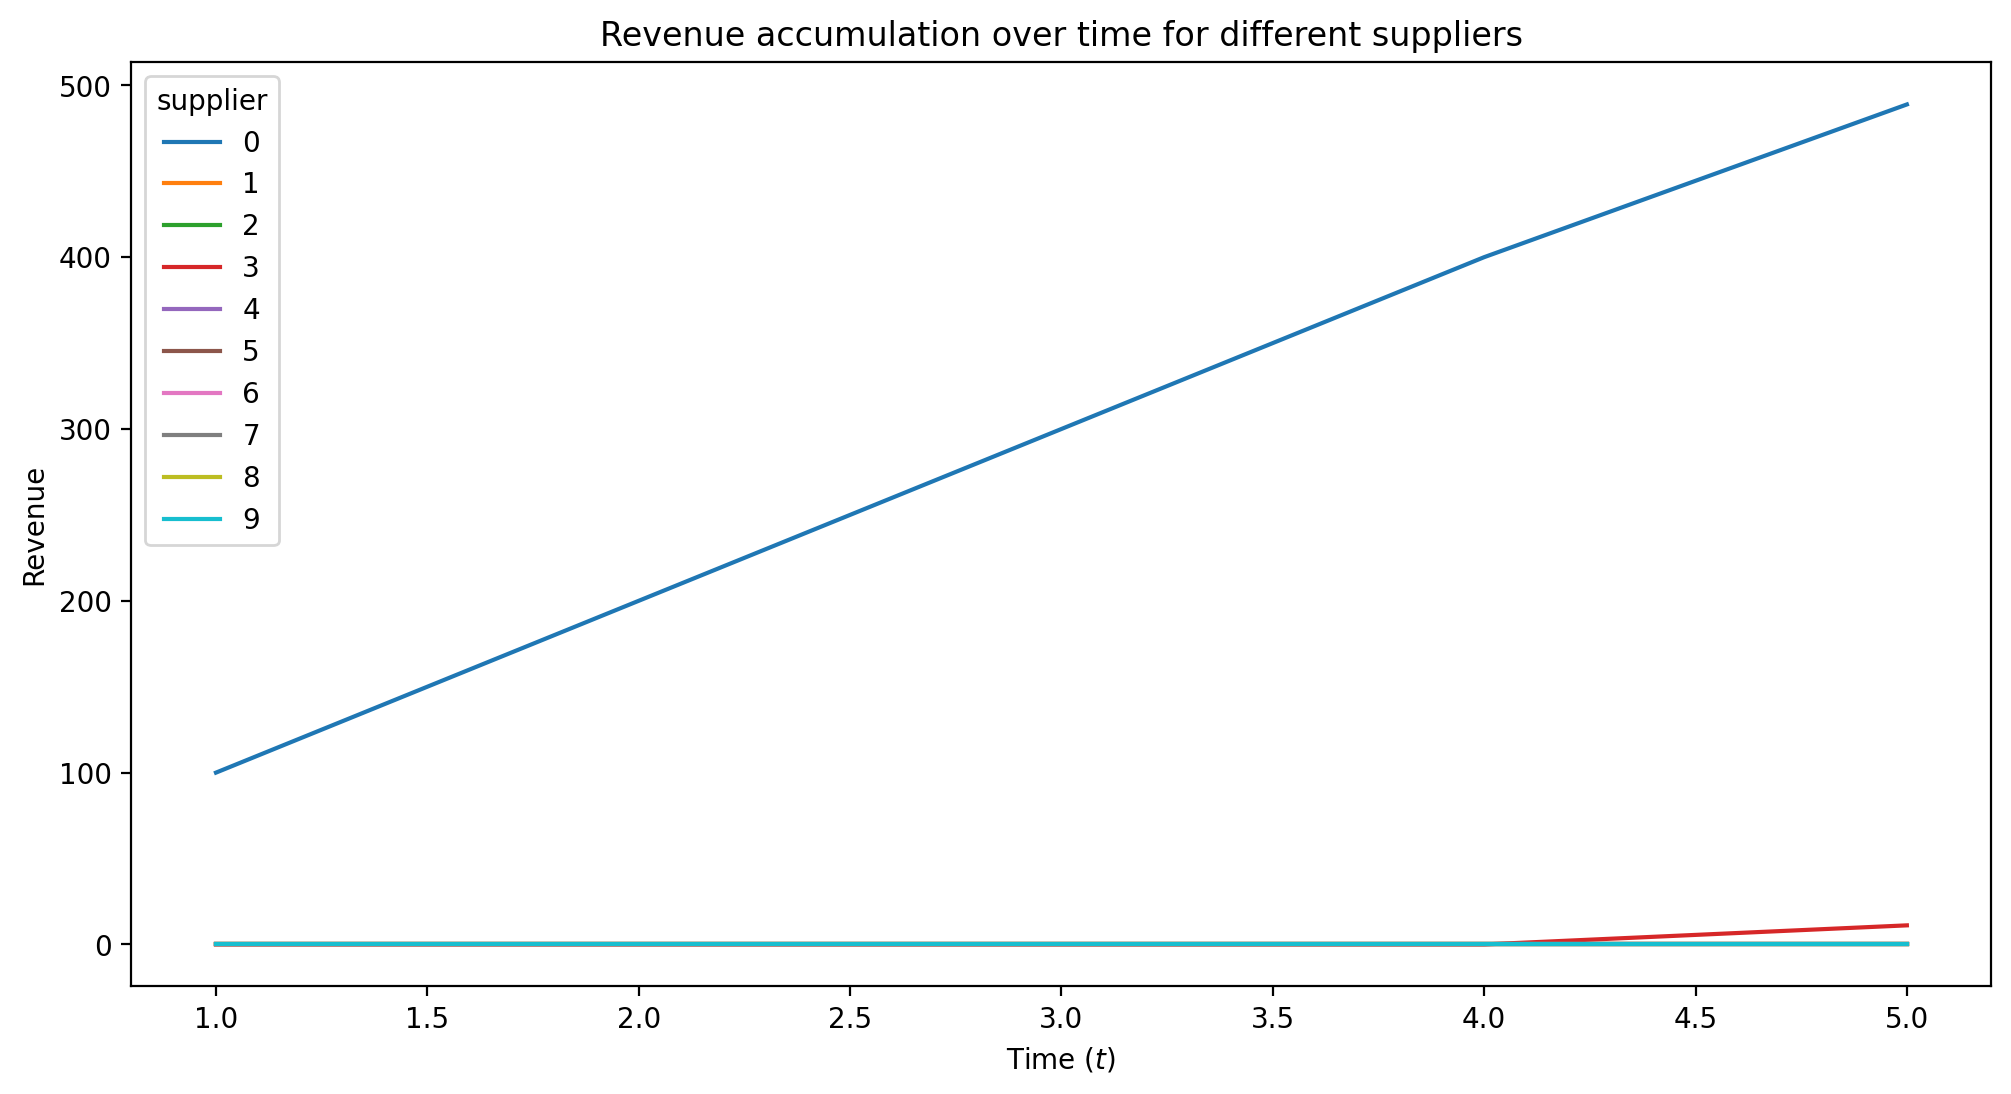

In [29]:
(
    omniscient_payments_df
    .pivot(index='timestamp',columns='supplier',values='revenue')
    .cumsum()
    .plot.line(
        title='Revenue accumulation over time for different suppliers',
        xlabel='Time ($t$)',
        ylabel='Revenue',
        figsize=(12,6),
    )
)


Explain your strategy. How does your agent work? Why did you choose this strategy?

🔵 **Answer**:

It is a very simple strategy, the agent bids slightly above the highest bid, if it is possible.
Because the bids are sorted, there is no need to bid a lot higher, just a little bit higher, and so the agents doesn't need to spend a lot of money.
Also, because the other agents are maxed at 50% of their budget, and they all start with the same budget, the agent will always be able to bid slightly above the highest bid, making sure he will get the top spot always